In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import math
import random
from scipy.stats import t
import scipy.stats as st
import numpy as np
import collections
from numbers import Number
from __future__ import division
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 15, 6
use_colours = {0: "blue", 1: "red"}

In [2]:
df = pd.read_csv("fact_price_weekly_cheese.csv")

In [4]:
df.head()

,fact,year,month,yearmonth,date,geo,geo_partner,CHEESE,product_sk,product,product_code,unit,currency_sk,curr_value,lag_value,source
0,price,2016,10,201610,2016-10-08,UNITED STATES,ns,CHEESE,1731,Cheddar Block,ns,EUR/kg,408690,4.0333,0,bordbia_dairy_price
1,price,2016,10,201610,2016-10-01,UNITED KINGDOM,ns,CHEESE,1729,Cheddar English,ns,EUR/kg,408624,3.0500,0,bordbia_dairy_price
2,price,2016,10,201610,2016-10-01,UNITED KINGDOM,ns,CHEESE,1728,Cheddar Southern Irish,ns,EUR/kg,408624,3.0250,0,bordbia_dairy_price
3,price,2016,10,201610,2016-10-01,OCEANIA,ns,CHEESE,1727,Cheddar,ns,EUR/kg,408624,3.8875,0,bordbia_dairy_price
4,price,2016,10,201610,2016-10-01,UNITED STATES,ns,CHEESE,1731,Cheddar Block,ns,EUR/kg,408624,4.1270,0,bordbia_dairy_price


In [5]:
df.date = df.date.astype(str)

In [8]:
df['date'] = pd.to_datetime(df['date'])


In [9]:
df = df.set_index("date")
df.curr_value = df.curr_value.fillna(np.mean(df.curr_value))

In [10]:
ts = df["curr_value"]

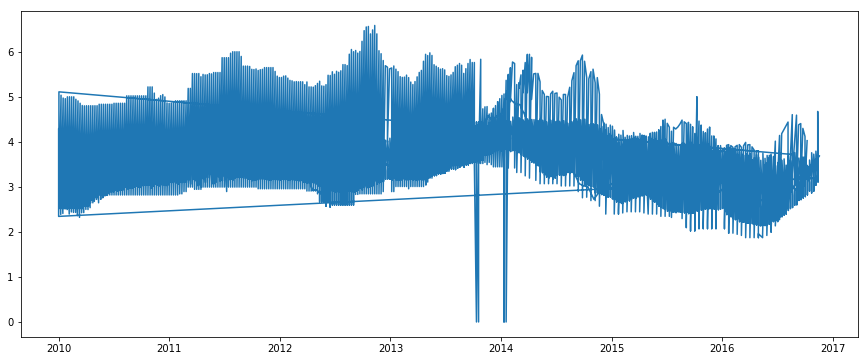

In [11]:
plt.plot(ts)


In [12]:

index = df.index.values

In [13]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

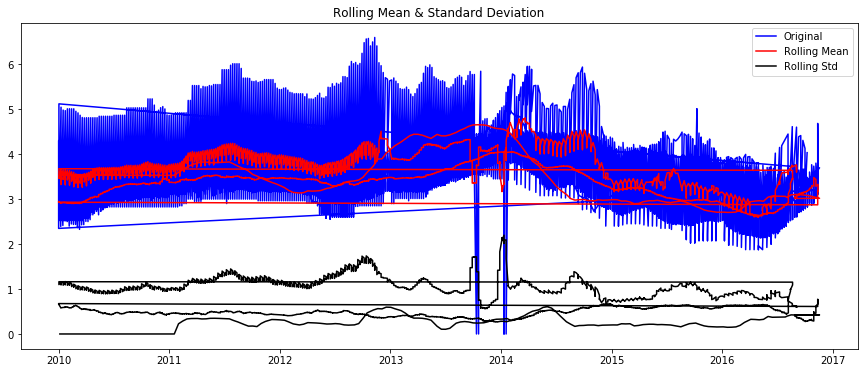

Results of Dickey-Fuller Test:
Test Statistic                   -3.566588
p-value                           0.006433
#Lags Used                       28.000000
Number of Observations Used    2657.000000
Critical Value (5%)              -2.862628
Critical Value (1%)              -3.432814
Critical Value (10%)             -2.567349
dtype: float64


In [14]:
test_stationarity(ts)

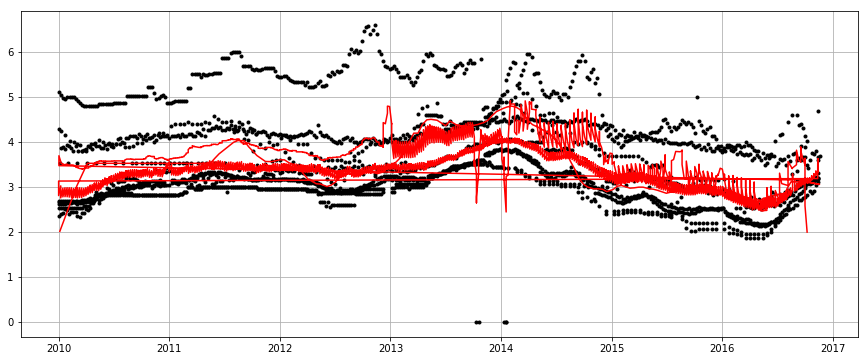

In [17]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

x = index
y = df.curr_value


plt.plot(x,y,"k.")
y_av = movingaverage(y, 7)
plt.plot(x, y_av,"r")
plt.grid(True)
plt.show()

std = np.std(y_av)
events= []
ind = []
for i in range(len(df.curr_value)):
    if df["curr_value"][i] > y_av[i]+std:
        events.append(df["curr_value"][i])

In [18]:
len(events)

759

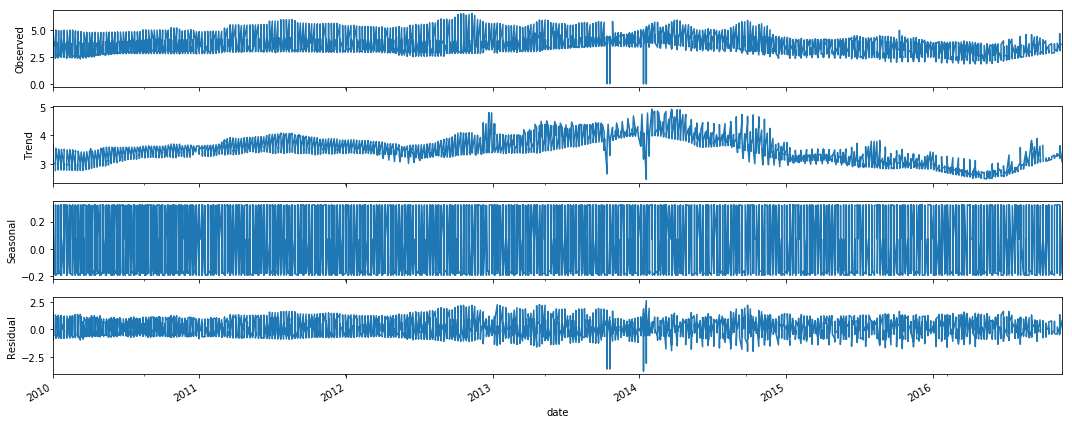

In [20]:
res = sm.tsa.seasonal_decompose(df["curr_value"],freq=7)
resplot = res.plot()

In [21]:
random = res.resid
min_res = np.mean(random) - 3*np.std(random)
max_res = np.mean(random) + 3*np.std(random)

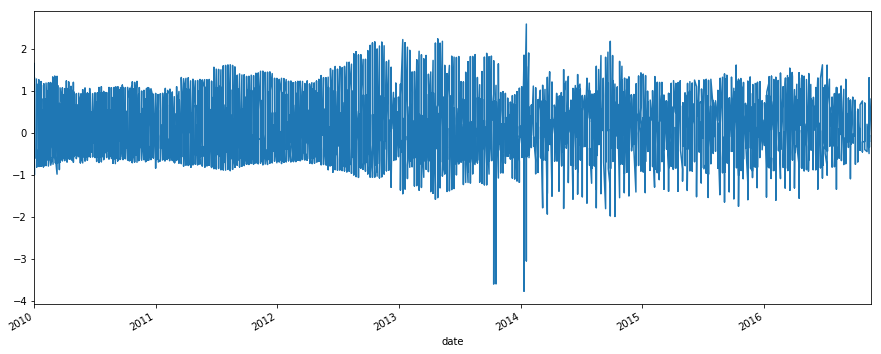

In [22]:
random.plot()

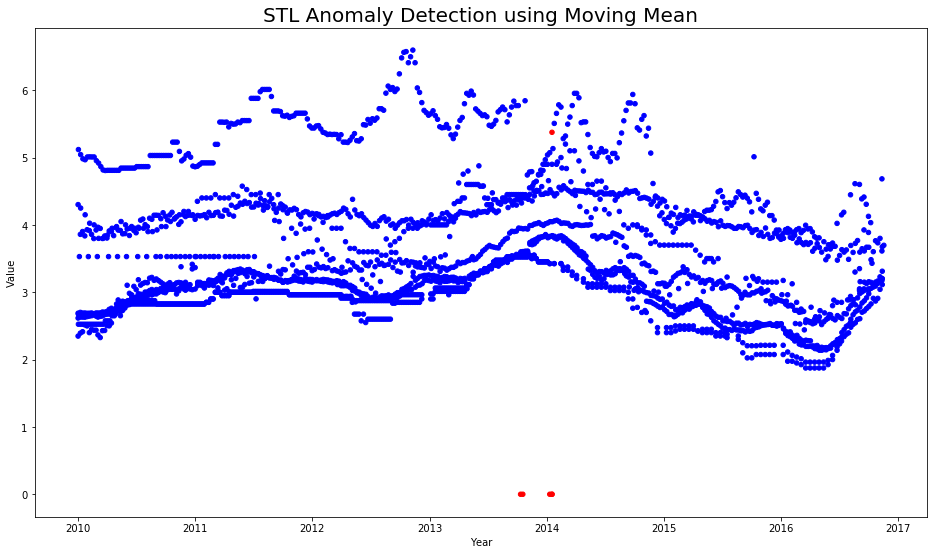

In [25]:
anomaly = []
for i in random:
    if i > max_res or i < min_res:
        anomaly.append(True)
    else:
        anomaly.append(False)

plt.figure(figsize=(16,9))
plt.scatter(random.index, df.curr_value, c=[use_colours[x] for x in anomaly], s=20)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("STL Anomaly Detection using Moving Mean", fontsize="20")

In [30]:
def running_median_numpy(seq,window_size):
    data = np.array(seq, dtype=float)
    result = []
    for i in range(1, window_size):
        window = data[:i]
        result.append(np.median(window))
    for i in xrange(len(data)-window_size+1):
        window = data[i:i+window_size]
        result.append(np.median(window))
    return result

In [31]:
random_med = running_median_numpy(df.curr_value.values,7)

In [32]:
random_med = np.array(random_med)

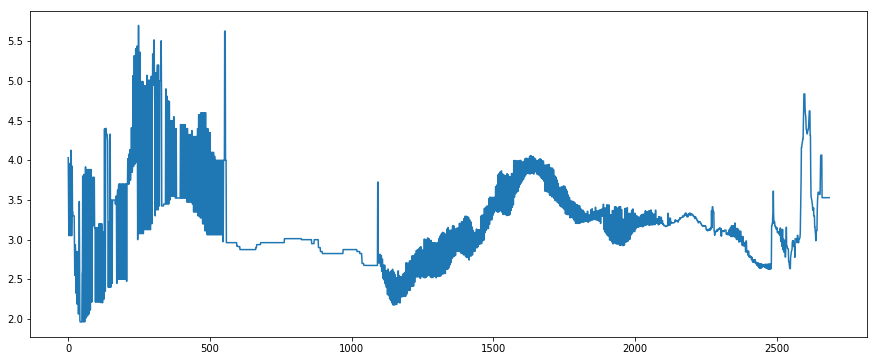

In [33]:
plt.plot(random_med)

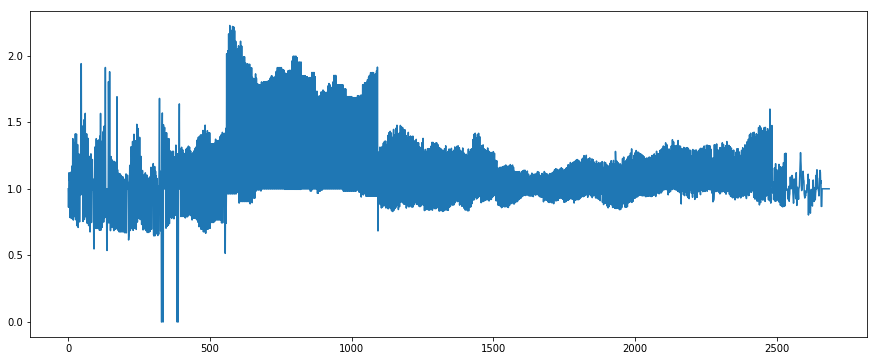

In [35]:
detrend_median = df.curr_value.values / random_med
plt.plot(detrend_median)

In [36]:
seasonal = np.mean(detrend_median)

In [37]:
random = df.curr_value.values / (random_med * seasonal)

In [38]:
detrend_median_wo_anom = running_median_numpy(random,3)

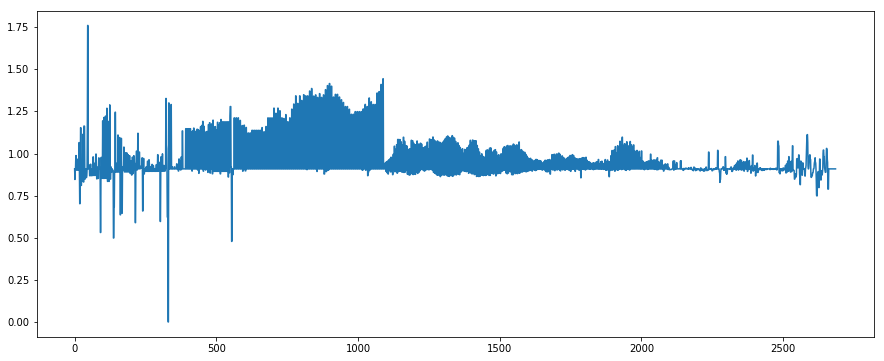

In [39]:
plt.plot(detrend_median_wo_anom)

In [40]:
min_res_med = np.mean(detrend_median_wo_anom) - 5*np.std(detrend_median_wo_anom)
max_res_med = np.mean(detrend_median_wo_anom) + 5*np.std(detrend_median_wo_anom)

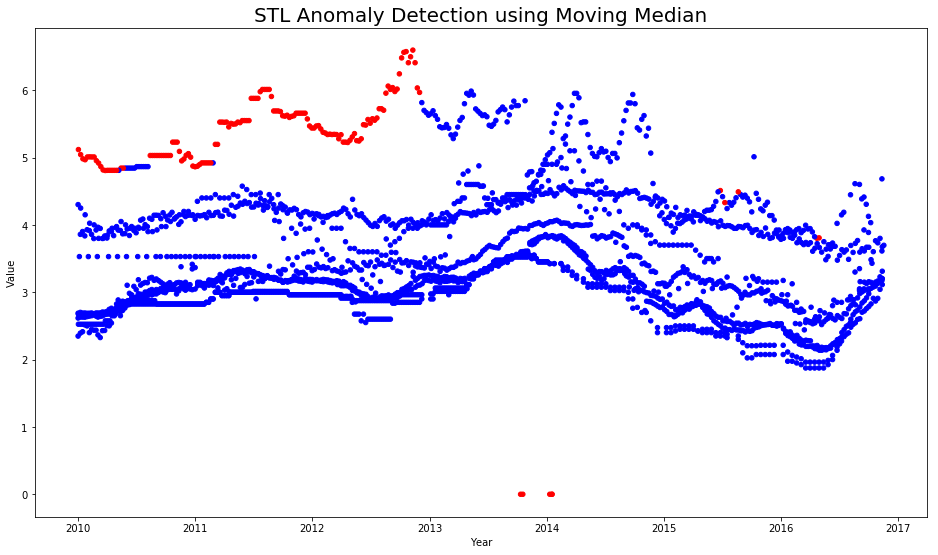

In [41]:
anomaly = []
for i in random:
    if i > max_res_med or i < min_res_med:
        anomaly.append(True)
    else:
        anomaly.append(False)

use_colours = {0: "blue", 1: "red"}
#ax.scatter(a,b,c,c=[use_colours[x[0]] for x in df["Outlier"]],s=50)

plt.figure(figsize=(16,9))
plt.scatter(df.index, df.curr_value, c=[use_colours[x] for x in anomaly], s=20)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("STL Anomaly Detection using Moving Median", fontsize="20")

Since the p value is less than than the 5 % and 10 % critical value and very close to the 1 % level, the null hypothesis can be 
rejected and it can be concluded that the signal is stationary

As can be seen these features doesn't add any variance to the model, moreover id can also be neglected. only date,geo location and the price are relevant features 

Label Encoding

In [42]:
df["geo"] = df["geo"].astype('category').cat.codes

Imputation and building the upper and lower bounds for building the Anomaly threshold

In [44]:

sd = np.std(df["curr_value"])
mean = np.mean(df["curr_value"])
# Upper Bound
X_upper = mean + sd*4
# Lower Bound
X_lower = mean - sd*4

Generating the outliers for evaluation

In [45]:
rng = np.random.RandomState(42)

# Generate some abnormal novel observations
X_outliers_1 = rng.uniform(low=X_upper*0.9, high=X_upper*2, size=(50, 1))
X_outliers_2 = rng.uniform(low=-X_lower*1.5, high=-X_lower*2, size=(50, 1))

In [46]:
Outliers = []
Outliers.extend(X_outliers_1)
Outliers.extend(X_outliers_2)

Creating the outlier Class and inserting the anomalous data in the dataset

In [47]:
df["Actual"] = False

In [50]:
df = df.reset_index(drop=True)
idx = df.index
for i in Outliers:
    loc = np.random.randint(0, len(df))
    df.loc[loc,"curr_value"] = i
    df.loc[loc,"Actual"] = True

Extracting the features for Boxplot visualization

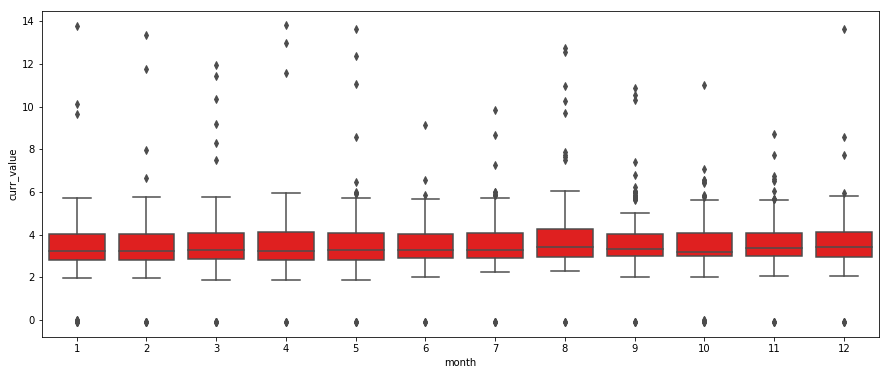

In [51]:
import seaborn as sns

ax = sns.boxplot(x="month", y="curr_value", data=df,color="red")
#ax = sns.swarmplot(x="Month", y="price", data=df_year, color=".25")

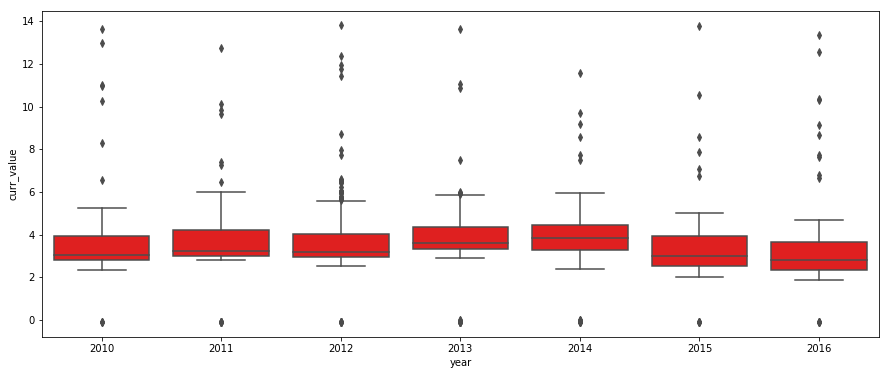

In [52]:
import seaborn as sns

ax = sns.boxplot(x="year", y="curr_value", data=df,color="red")

We can see some pretty obvious outliers in Month 1 and 6

The visualization neatly describes the anomalous features each year

Like Discussed earlier, only the date, geo and the price fields are relevant with respect to the anomaly detection and hence only including those

In [53]:
df_corr = df.corr()
print(df_corr)

                 year     month  yearmonth       geo  product_sk  currency_sk  \
year         1.000000 -0.050333   0.999844 -0.081955    0.057360     0.989522   
month       -0.050333  1.000000  -0.032710 -0.010038    0.006937     0.093871   
yearmonth    0.999844 -0.032710   1.000000 -0.082193    0.057525     0.991905   
geo         -0.081955 -0.010038  -0.082193  1.000000   -0.673152    -0.082781   
product_sk   0.057360  0.006937   0.057525 -0.673152    1.000000     0.057618   
currency_sk  0.989522  0.093871   0.991905 -0.082781    0.057618     1.000000   
curr_value  -0.075537  0.032865  -0.075012  0.225921   -0.077282    -0.070487   
lag_value         NaN       NaN        NaN       NaN         NaN          NaN   
Actual       0.021223 -0.005643   0.021139  0.015261   -0.004805     0.020110   

             curr_value  lag_value    Actual  
year          -0.075537        NaN  0.021223  
month          0.032865        NaN -0.005643  
yearmonth     -0.075012        NaN  0.021139  
g

In [54]:
df.head()

,fact,year,month,yearmonth,geo,geo_partner,CHEESE,product_sk,product,product_code,unit,currency_sk,curr_value,lag_value,source,Actual
0,price,2016,10,201610,4,ns,CHEESE,1731,Cheddar Block,ns,EUR/kg,408690,4.0333,0,bordbia_dairy_price,False
1,price,2016,10,201610,3,ns,CHEESE,1729,Cheddar English,ns,EUR/kg,408624,3.0500,0,bordbia_dairy_price,False
2,price,2016,10,201610,3,ns,CHEESE,1728,Cheddar Southern Irish,ns,EUR/kg,408624,3.0250,0,bordbia_dairy_price,False
3,price,2016,10,201610,2,ns,CHEESE,1727,Cheddar,ns,EUR/kg,408624,3.8875,0,bordbia_dairy_price,False
4,price,2016,10,201610,4,ns,CHEESE,1731,Cheddar Block,ns,EUR/kg,408624,4.1270,0,bordbia_dairy_price,False


In [55]:
from sklearn import preprocessing
df = df.dropna()
df_new = df[["geo","curr_value","currency_sk","product_sk"]]
#df_new = df["price"]
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_new)
df_scaled = pd.DataFrame(df_scaled)
df_scaled = df_scaled.astype('float32')

In [56]:
len(df_scaled)

2686

Resizing the array for training autoencoder neural network 

In [57]:
array = np.array(df_scaled)
row,column = array.shape
array = array.reshape((1,row,column))

In [58]:
array.shape

(1, 2686, 4)

In [59]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = column  # 80 floats -> compression of factor 0.8, assuming the input is 100 floats

# this is our input placeholder
input = Input(shape=(row,column))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(column, activation='sigmoid')(encoded)
#rps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)
encoder = Model(inputs=input, outputs=encoded)

Using TensorFlow backend.


In [60]:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=array.shape[1:])
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='mse')

In [61]:
# Just compute the distance before learning (show be very bad !)

test_encode = encoder.predict(array)
test_decode = decoder.predict(test_encode)
test_encode = test_encode.reshape((row,column))
test_decode = test_decode.reshape((row,column))
test_array = array.reshape((row,column))
naivedist = np.zeros(len(df_scaled.values))
for i, x in enumerate(array):
    naivedist[i] = np.linalg.norm(x-test_decode[i]) 

In [62]:
df["naivedist"] = naivedist

In [63]:
autoencoder.fit(array, array,
                epochs=2500,
                batch_size=100,
                shuffle=True,
                verbose=0)

In [64]:
encoded = encoder.predict(array)
decoded = decoder.predict(encoded)

In [65]:
encoded = encoded.reshape((row,column))
decoded = decoded.reshape((row,column))
array = array.reshape((row,column))


In [66]:
dist = np.zeros(len(df_scaled.values))
for i, x in enumerate(array):
    dist[i] = np.linalg.norm(x-decoded[i]) 

In [67]:
df["dist"] = dist

In [69]:
def mad_based_outlier(points, thresh=4):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D8., Editor.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

def doubleMADsfromMedian(y,thresh=4):
    # warning: this function does not check for NAs
    # nor does it address issues when 
    # more than 50% of your data have identical values
    m = np.median(y)
    abs_dev = np.abs(y - m)
    left_mad = np.median(abs_dev[y <= m])
    right_mad = np.median(abs_dev[y >= m])
    y_mad = left_mad * np.ones(len(y))
    y_mad[y > m] = right_mad
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=99):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

# Valid Only for Non Stationary time series
def anomaly_detector2(feature,Z=3):
    results = []
    diff_X = []
    index = []
    X= np.sort(feature.price)
    Y = feature[feature.columns[0]]
    for i in range(len(X)):
        if i ==0:
            value = X[i]
        else:
            value = X[i] - X[i-1]
                
        diff_X.append(value)
    X_mean = np.mean(diff_X)
    X_std = np.std(diff_X)
    X_upper = X_mean + X_std*Z
    X_lower = X_mean - X_std*Z
    j = 0
    for i in diff_X:
        if X_upper < i or X_lower > i:
            results.append(True)
            index.append(Y[j])
        else:
            results.append(False)
        j = j + 1
    return results,index

# Model for stationary time series
def anomaly_detector1(feature,Z=3):
    results = []
    X= np.sort(feature)
    X_mean = np.mean(X)
    X_std = np.std(X)
    X_upper = X_mean + X_std*Z
    X_lower = X_mean - X_std*Z
    for i in feature:
        if X_upper < i or X_lower > i:
            results.append(True)
        else:
            results.append(False)
    return results


In [70]:
results_mad_AE = mad_based_outlier(dist)
results_mad_Normal = mad_based_outlier(df.curr_value)
results_per = percentile_based_outlier(df.curr_value)
results_per_AE = percentile_based_outlier(dist)
results_doublemad_AE = doubleMADsfromMedian(dist)
results_doublemad_Normal = doubleMADsfromMedian(df.curr_value)
results_AD = anomaly_detector1(df.curr_value)
results_AD_AE = anomaly_detector1(dist)

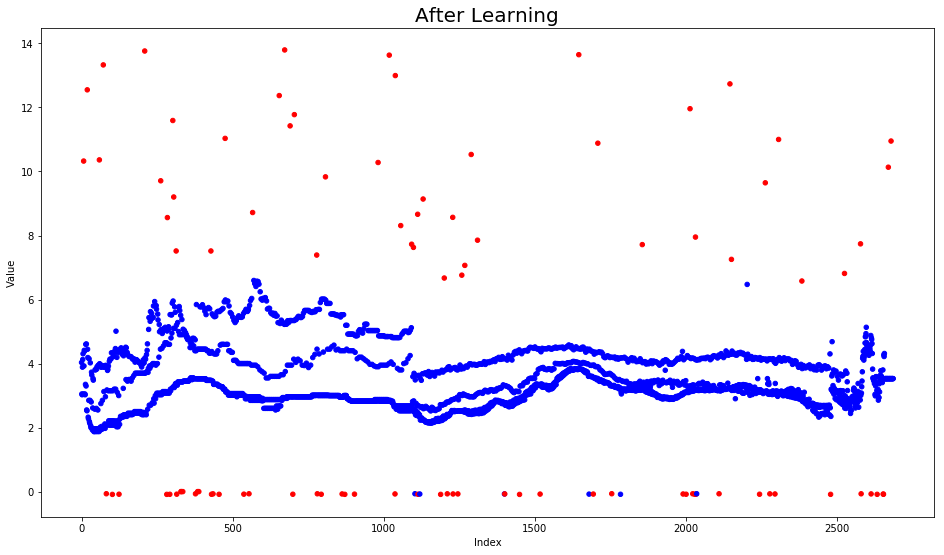

In [71]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_mad_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

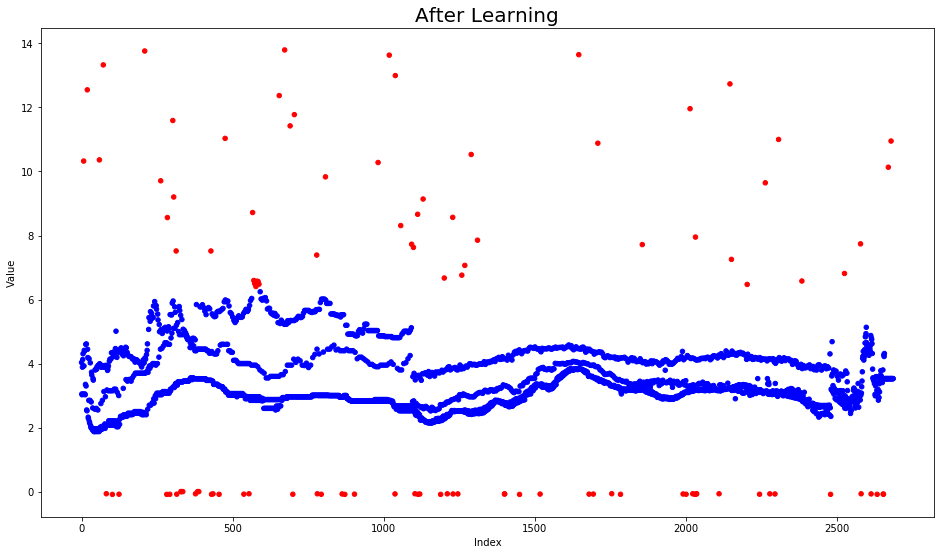

In [72]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_mad_Normal], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

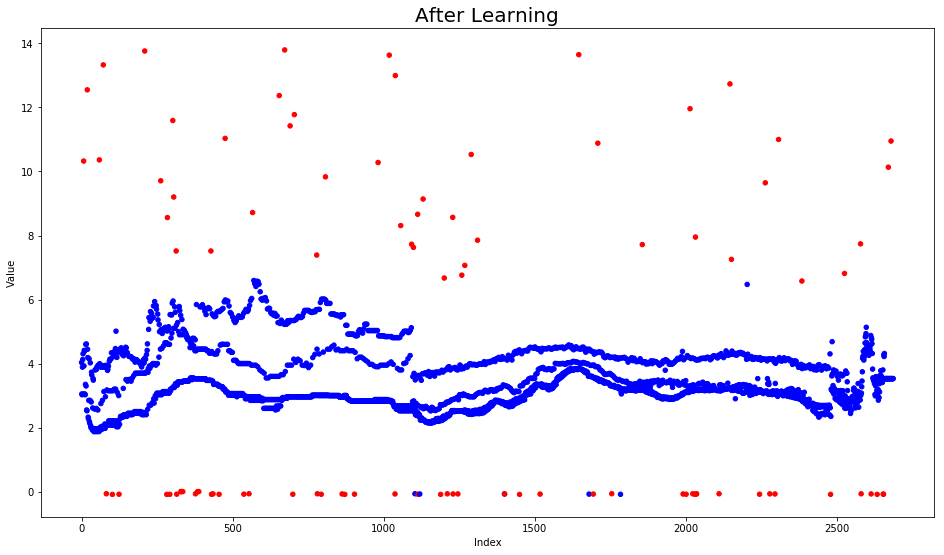

In [73]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_doublemad_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

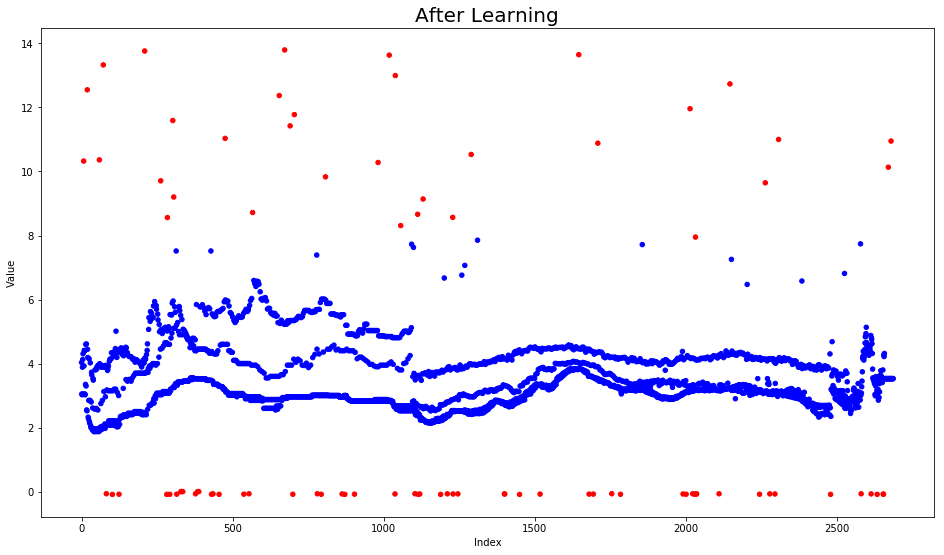

In [74]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_doublemad_Normal], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

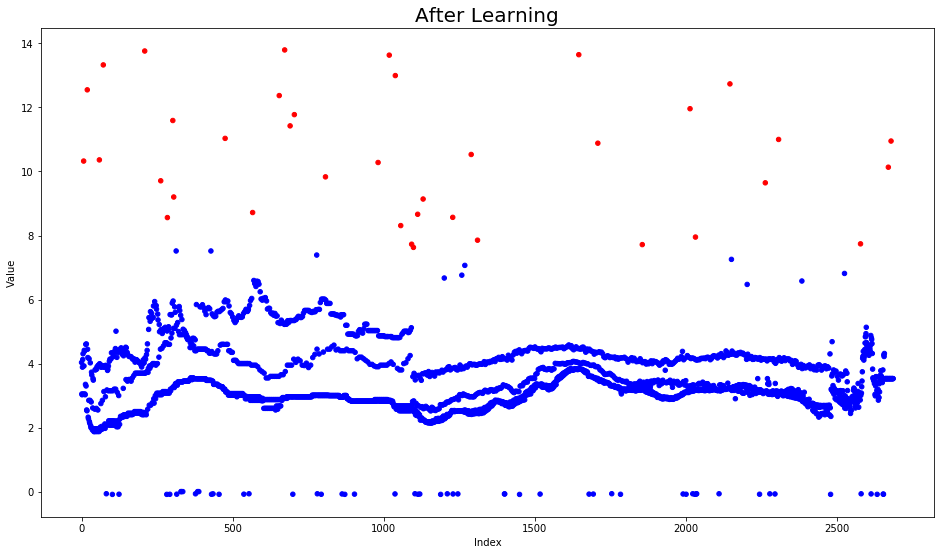

In [75]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_AD], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

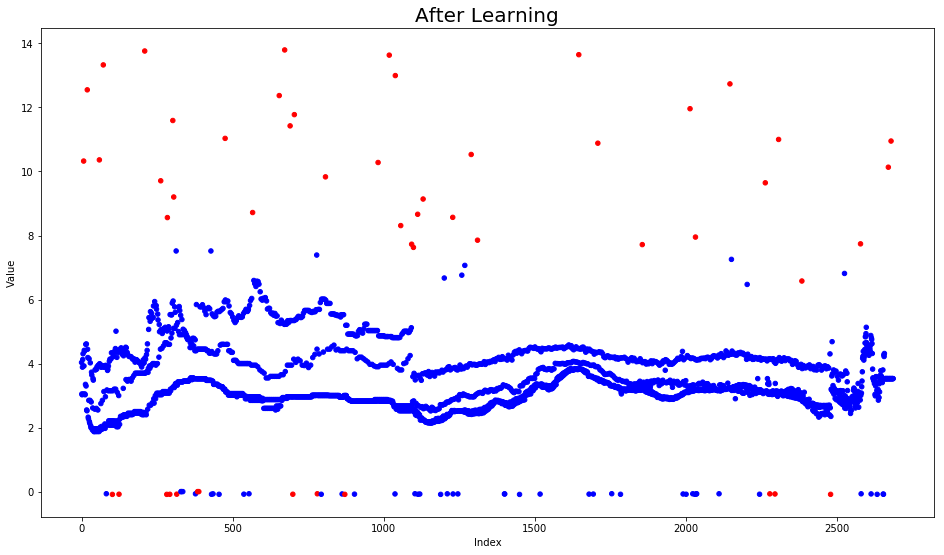

In [76]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_AD_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

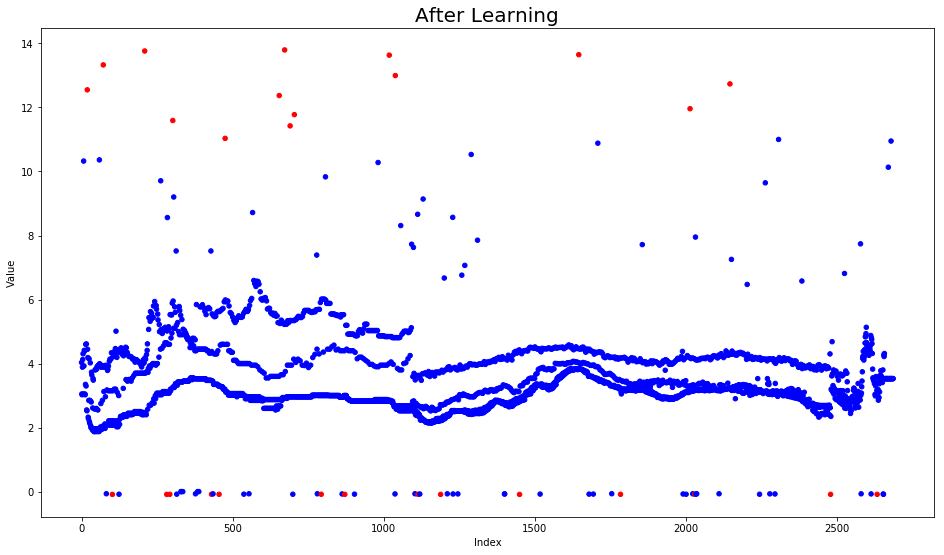

In [77]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_per], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

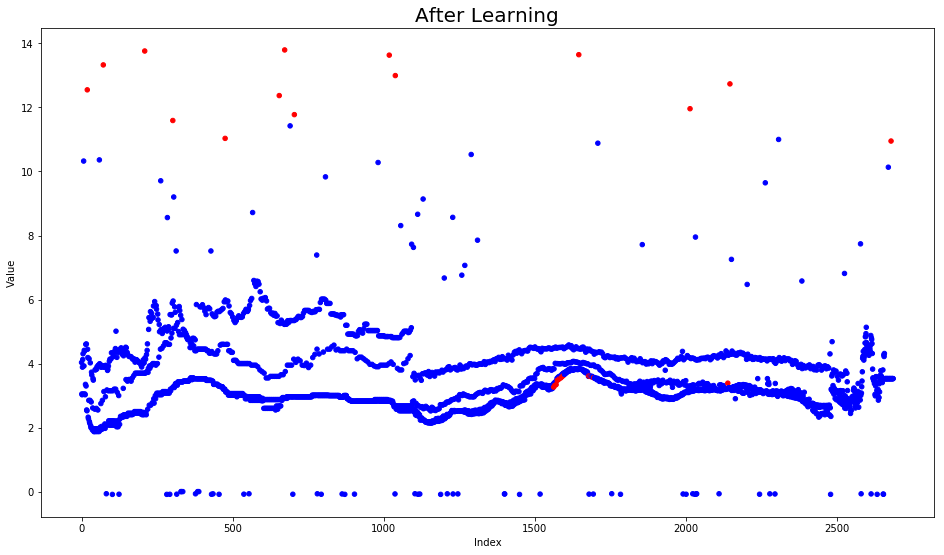

In [78]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_per_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

In [79]:
df["Outlier_MAD_AE"] = results_mad_AE
df["Outlier_MAD_Normal"] = results_mad_Normal 
df["Outlier_PER"] = results_per
df["Outlier_PER_AE"] = results_per_AE
df["Outlier_DoubleMAD_AE"] = results_doublemad_AE
df["Outlier_DoubleMAD_Normal"] = results_doublemad_Normal
df["Outlier_AD"] = results_AD
df["Outlier_AD_AE"] = results_AD_AE

In [94]:
cm=confusion_matrix(df.Actual,df.Outlier_MAD_AE)
print("Accuracy of MAD based Outlier detection using Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection using Autoencoders is :"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_MAD_AE)))
print("\n")
cm=confusion_matrix(df.Actual,df.Outlier_MAD_Normal)
print("Accuracy of MAD based Outlier detection  :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_MAD_Normal)))

Accuracy of MAD based Outlier detection using Autoencoders is :0.995532390171
Precision of MAD based Outlier detection using Autoencoders is :0.928571428571
Cohen's Kappa: 0.935827088327


Accuracy of MAD based Outlier detection  :0.99590469099
Precision of MAD based Outlier detection:1.0
Cohen's Kappa: 0.944736438487


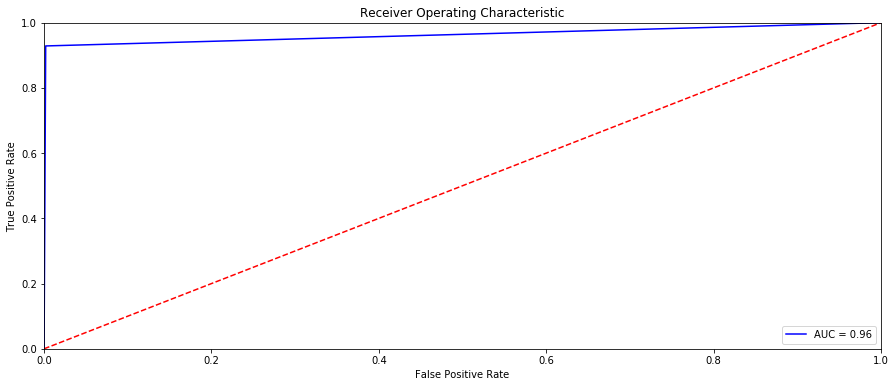

In [154]:
fpr, tpr, threshold = roc_curve(df.Actual,df.Outlier_MAD_AE)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [153]:
cm=confusion_matrix(df.Actual,df.Outlier_DoubleMAD_AE)
print("Accuracy of Double MAD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of Double MAD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_DoubleMAD_AE)))
print("\n")
cm=confusion_matrix(df.Actual,df.Outlier_DoubleMAD_Normal)
print("Accuracy of Double MAD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of Double MAD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_DoubleMAD_Normal)))

Accuracy of Double MAD based Outlier detection without Autoencoders is :0.99590469099
Precision of Double MAD based Outlier detection without Autoencoders is:0.938775510204
Cohen's Kappa: 0.94146501888


Accuracy of Double MAD based Outlier detection without Autoencoders is :0.992553983619
Precision of Double MAD based Outlier detection without Autoencoders is:0.84693877551
Cohen's Kappa: 0.88862812741


In [152]:
cm=confusion_matrix(df.Actual,df.Outlier_AD_AE)
print("Accuracy of AD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of AD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_AD_AE)))
print("\n")
cm=confusion_matrix(df.Actual,df.Outlier_AD)
print("Accuracy of AD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of AD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_AD)))

Accuracy of AD based Outlier detection without Autoencoders is :0.981384959047
Precision of AD based Outlier detection without Autoencoders is:0.510204081633
Cohen's Kappa: 0.658015624841


Accuracy of AD based Outlier detection without Autoencoders is :0.977661950856
Precision of AD based Outlier detection without Autoencoders is:0.387755102041
Cohen's Kappa: 0.549641188438


In [91]:
cm=confusion_matrix(df.Actual,df.Outlier_PER_AE)
print("Accuracy of PER based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of PER based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_PER_AE)))
print("\n")
cm=confusion_matrix(df.Actual,df.Outlier_PER)
print("Accuracy of PER based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of PER based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_PER)))

Accuracy of PER based Outlier detection without Autoencoders is :0.963514519732
Precision of PER based Outlier detection without Autoencoders is:0.142857142857
Cohen's Kappa: 0.209402068792


Accuracy of PER based Outlier detection without Autoencoders is :0.973938942666
Precision of PER based Outlier detection without Autoencoders is:0.285714285714
Cohen's Kappa: 0.435287191994


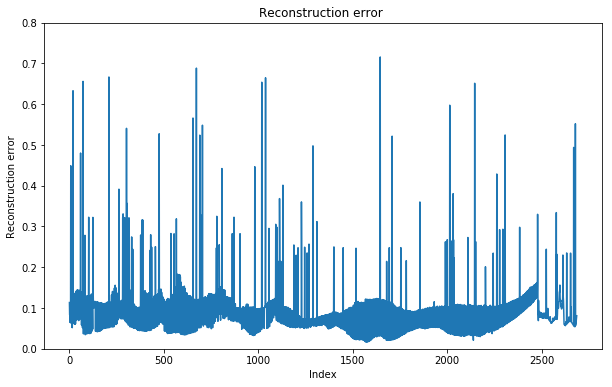

In [95]:
plt.figure(figsize=(10,6))
plt.plot(dist)
#plt.xlim((0,100))
plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error ")

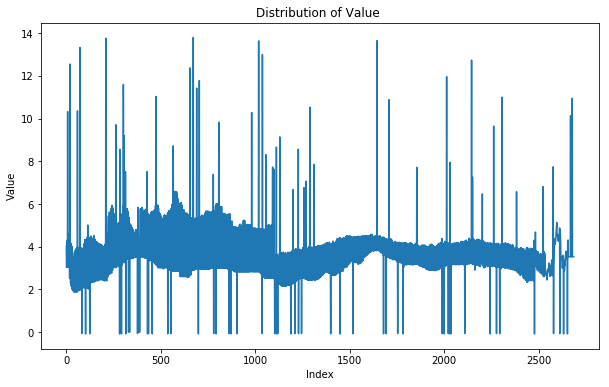

In [96]:
value = np.array(df["curr_value"])
plt.figure(figsize=(10,6))
plt.plot(value)

#plt.xlim((0,1000))
#plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("Distribution of Value ")

In [100]:
df_new.head()

,geo,curr_value,currency_sk,product_sk
0,4,4.0333,408690,1731
1,3,3.0500,408624,1729
2,3,3.0250,408624,1728
3,2,3.8875,408624,1727
4,4,4.1270,408624,1731


In [143]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
df_new = df[["geo","currency_sk","product_sk","curr_value"]]
X_train,X_test = train_test_split(df_new,test_size=0.2)
X_test = X_test.reset_index(drop=True)
X_test["Actual"] = False
for i in Outliers:
    loc = np.random.randint(0, len(X_test))
    #print(X_test.loc[loc,"price"])
    X_test.loc[loc,"curr_value"] = i
    #print(X_test.loc[loc,"price"])
    X_test.loc[loc,"Actual"] = True
    #print(X_test.loc[loc,"Actual"])
X_test_sub = X_test.drop("Actual",axis=1)
#print(X_test)
# fit the model
clf = IsolationForest(max_samples="auto",n_estimators=100,bootstrap=True,contamination=0.01,)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test_sub)

In [144]:
y_pred_test[y_pred_test ==1] = False
y_pred_test[y_pred_test ==-1] = True


In [145]:
from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score
cm=confusion_matrix(X_test.Actual,y_pred_test)

In [146]:
cm

array([[448,   3],
       [ 65,  22]])

In [147]:
coh = cohen_kappa_score(X_test.Actual,y_pred_test)
print(coh)

0.345615855185


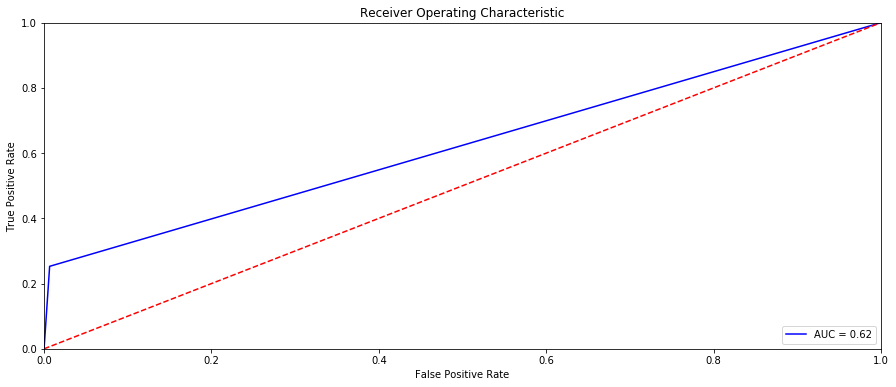

In [148]:
fpr, tpr, threshold = roc_curve(X_test.Actual,y_pred_test)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [149]:
print("Accuracy of Isolation Forest :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of Isolation Forest:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))

Accuracy of Isolation Forest :0.873605947955
Precision of Isolation Forest:0.252873563218


In [150]:
X_test_sub.reset_index()
X_test_sub = X_test_sub.reset_index()
X_test_sub = X_test_sub.reset_index()
X_test_sub.columns.values[0] = "new_index"
X_test_sub["Actual"] = X_test["Actual"]

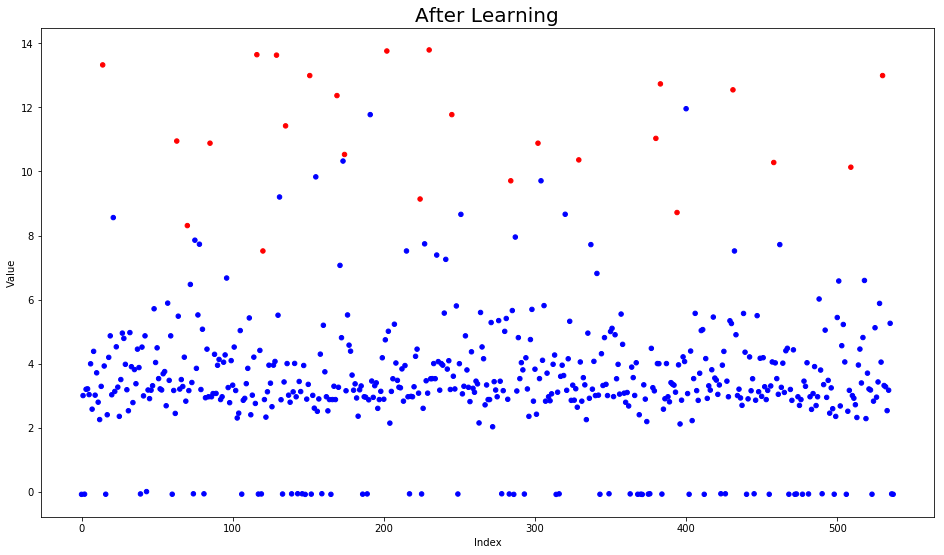

In [151]:
plt.figure(figsize=(16,9))
plt.scatter(X_test.index, X_test["curr_value"], c=[use_colours[x] for x in y_pred_test], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")